# Decision tree
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st
from itertools import combinations

In [3]:
model_name = "dtree"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Using randomised search to find optimal hyperparameters

In [4]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [5]:
regr = DecisionTreeRegressor()
tscv = TimeSeriesSplit(n_splits=3)

In [6]:
param_dist = {'max_depth': [None,2,4,6,8,10,12,14,16,18,20],
              'min_samples_split': st.randint(2, 50),
              'min_samples_leaf': st.randint(1, 100),
              'max_features': range(3,X.shape[1]+1)
             }
regr_cv = RandomizedSearchCV(estimator=regr,
            param_distributions=param_dist,
            n_iter=100,
            cv=tscv,
            iid=False,
            scoring='neg_mean_squared_error',
            verbose=2,
            n_jobs=-1)
regr_pipe = Pipeline([('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.4s finished


Pipeline(memory=None,
     steps=[('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
          error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_s...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [7]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [8]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score', inplace=True)
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
24,0.475170,0.003667,-7831.358522,-2598.551854,18,16,1,18,"{'max_depth': 18, 'min_samples_leaf': 1, 'max_...",1,-10902.100399,-3464.378456,-6278.766459,-2359.196859,-6313.208707,-1972.080245,0.223855,0.000472,2171.387932,632.300877
15,0.370001,0.003833,-8879.739238,-4478.483984,None,12,9,21,"{'max_depth': None, 'min_samples_leaf': 9, 'ma...",2,-12457.752947,-5849.460280,-7243.677563,-4103.239959,-6937.787203,-3482.751714,0.157177,0.000235,2533.117816,1001.975854
22,0.455669,0.011168,-9046.796252,-6088.979126,18,16,17,11,"{'max_depth': 18, 'min_samples_leaf': 17, 'max...",3,-13011.344506,-8329.932743,-7264.564614,-5540.655368,-6864.479638,-4396.349266,0.228680,0.010490,2808.113143,1652.021782
74,0.524503,0.003668,-9074.961336,-5497.280658,16,14,3,40,"{'max_depth': 16, 'min_samples_leaf': 3, 'max_...",4,-12707.235320,-7289.086165,-7354.868847,-5063.163179,-7162.779840,-4139.592629,0.240202,0.000237,2569.602468,1321.910454
5,0.398168,0.003834,-9263.333446,-5923.374870,12,16,10,37,"{'max_depth': 12, 'min_samples_leaf': 10, 'max...",5,-12833.941954,-7361.470830,-7485.886852,-5643.185543,-7470.171532,-4765.468236,0.169920,0.001179,2524.809641,1078.173428


Inspect the pairwise distribution of cross validation scores. Darker shades of blue indicate superior performance while the red star represents the optimal solution found.

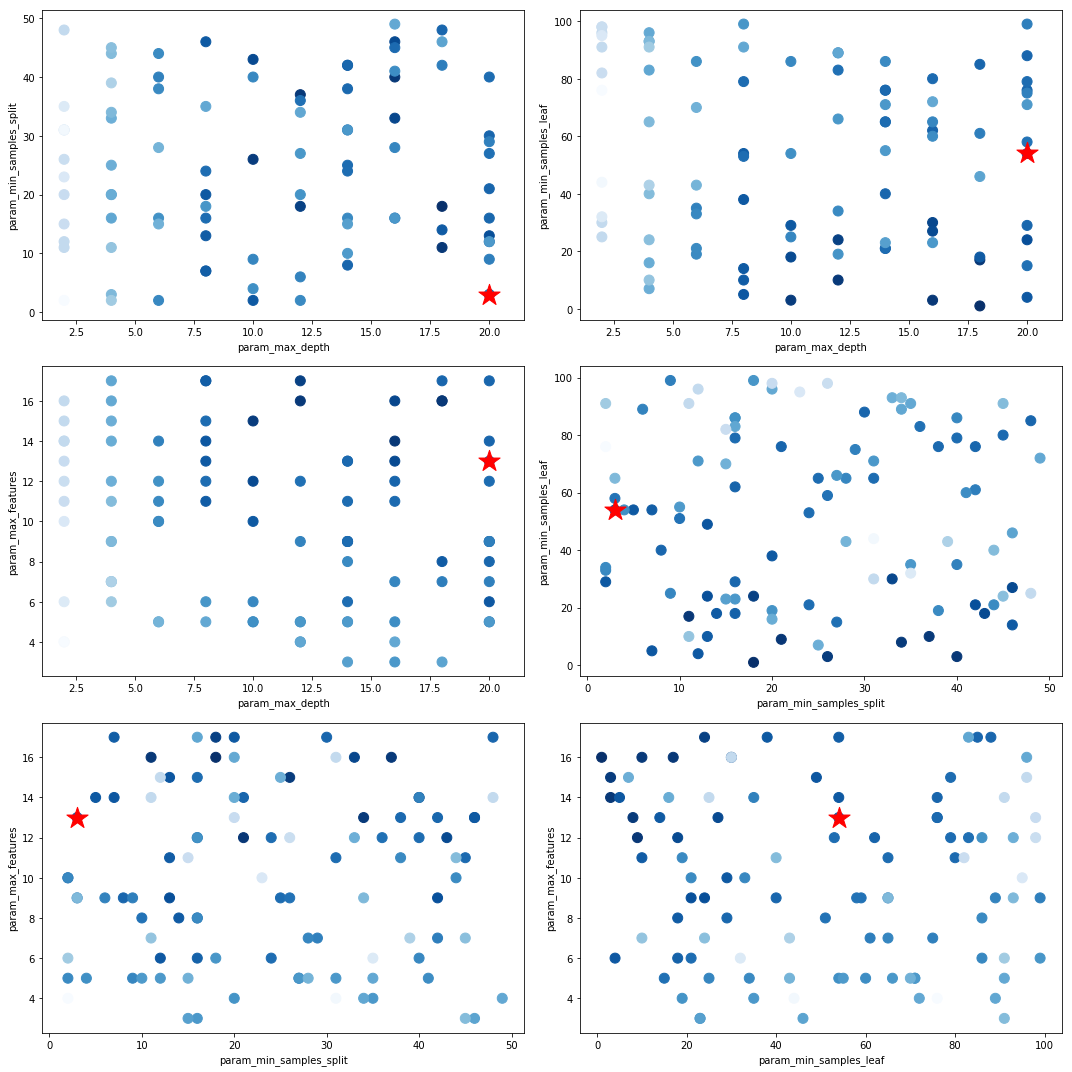

In [9]:
params = ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features']
gs = gridspec.GridSpec(3,2)
fig = plt.figure(figsize=(15, 15), tight_layout=True)
plt_best = cv_results.loc[[0]]
for idx, params in enumerate(combinations(params, 2)):
    ax = fig.add_subplot(gs[idx])
    plt.scatter(cv_results[params[0]], cv_results[params[1]], c=-np.log(-cv_results['mean_test_score']), s=100, cmap="Blues")
    plt.scatter(plt_best[params[0]], plt_best[params[1]], s=500, marker="*", c="r")
    plt.xlabel(params[0])
    plt.ylabel(params[1])

Inspect feature importance

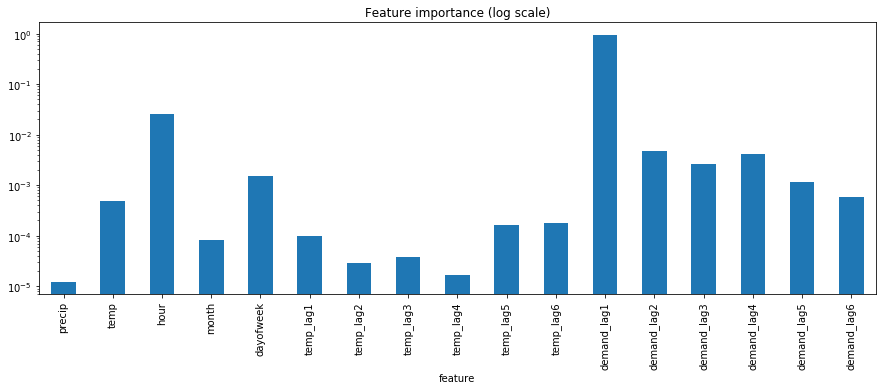

In [13]:
feature_importance = pd.DataFrame.from_dict({'feature':X.columns, 'importance':regr_pipe.named_steps['regr_cv'].best_estimator_.feature_importances_})
feature_importance.plot.bar('feature', 'importance', figsize=(15,5), logy=True, title='Feature importance (log scale)', legend=False)
plt.show()